In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
sns.set_style('darkgrid')
mpl.rcParams['figure.figsize'] = [18,10]

### Dominant colors in images
- All images consist of pixels 
- Each pixel has three values :RGB
- Perform k-means on standardized RGB values to find cluster centers
- Uses: Identify features in satellite images

### Tools to find dominant colors
- Convert image to pixels: `matplotlib.image.imread`
- Display colors of cluster centers: `matplotlib.pyplot.imshow`

In [3]:
import matplotlib.image as img
image = img.imread('data/sea.jpg')
image.shape

(810, 1305, 3)

In [5]:
r = []
g = []
b = []

for row in image:
    for pixel in row: 
        # A pixel contains RGB values
        temp_r, temp_g, temp_b = pixel
        r.append(temp_r)
        g.append(temp_g)
        b.append(temp_b)

In [10]:
from scipy.cluster.vq import whiten

In [11]:
pixels = pd.DataFrame({'red': r,
                      'blue': b,
                      'green': g,
                      'scaled_red': whiten(r),
                      'scaled_green': whiten(g),
                      'scaled_blue': whiten(b)})

,red,blue,green,scaled_red,scaled_green,scaled_blue
0,230,230,230,2.209515,2.883211,3.151454
1,230,230,230,2.209515,2.883211,3.151454
2,230,230,230,2.209515,2.883211,3.151454
3,230,230,230,2.209515,2.883211,3.151454
4,230,230,230,2.209515,2.883211,3.151454
...,...,...,...,...,...,...
1057045,26,55,46,0.249771,0.576642,0.753609
1057046,24,53,44,0.230558,0.551571,0.726205
1057047,21,52,44,0.201738,0.551571,0.712503
1057048,21,52,44,0.201738,0.551571,0.712503


In [12]:
from scipy.cluster.vq import kmeans, vq

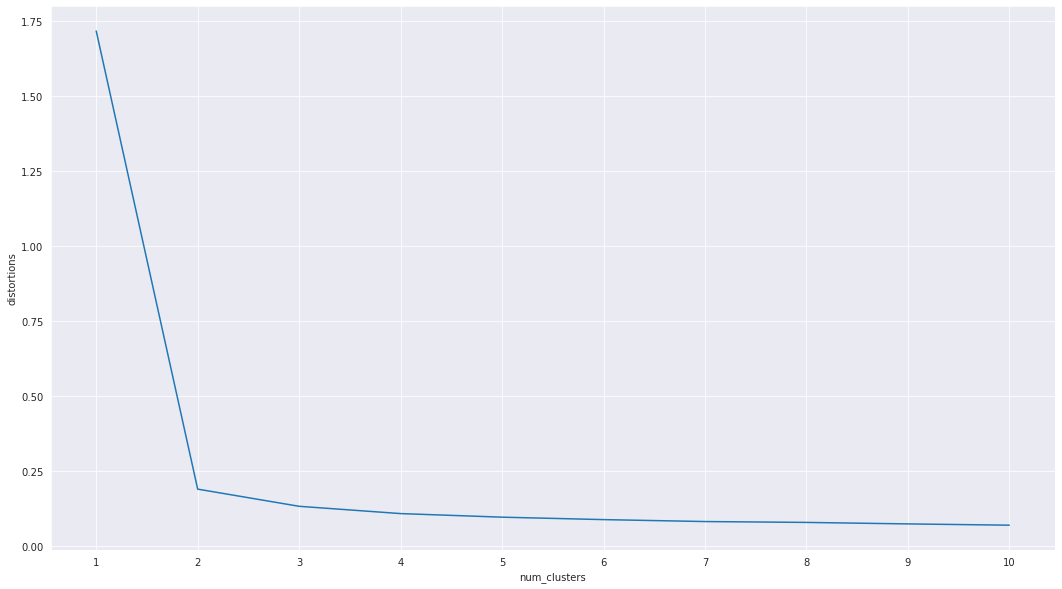

In [13]:
distortions = []
num_clusters = range(1, 11)

# Create a list of distortions from the kmeans method
for i in num_clusters: 
    cluster_centers, distortion = kmeans(pixels[['scaled_red', 'scaled_blue', 'scaled_green']], i)
    distortions.append(distortion)
    
# Create a data frame with two list - number of clusters and distortions 
elbow_plot = pd.DataFrame({'num_clusters': num_clusters,
                          'distortions': distortions})

# Create a line plot of num_clusters and distortions
sns.lineplot(x='num_clusters', y='distortions', data = elbow_plot)
plt.xticks(num_clusters)
plt.show()

### Find dominant colors

In [14]:
cluster_centers, _ = kmeans(pixels[['scaled_red', 'scaled_blue', 'scaled_green']], 2)

In [17]:
colors = []

# Find Standard Deviations 
r_std, g_std, b_std = pixels[['red', 'green', 'blue']].std()

# Scale actual RGB values in range of 0-1
for cluster_center in cluster_centers:
    scaled_r, scaled_g, scaled_b = cluster_center
    colors.append((
        scaled_r * r_std/255,
        scaled_g * g_std/255,
        scaled_b * b_std/255
    ))

### Display dominant colors

In [18]:
#Dimensions: 2 x 3 (N x 3 matrix)
print(colors)

[(0.08012482861586387, 0.37300684380669996, 0.2573556985103397), (0.892953171123333, 0.9834286890957886, 0.8213044431555168)]


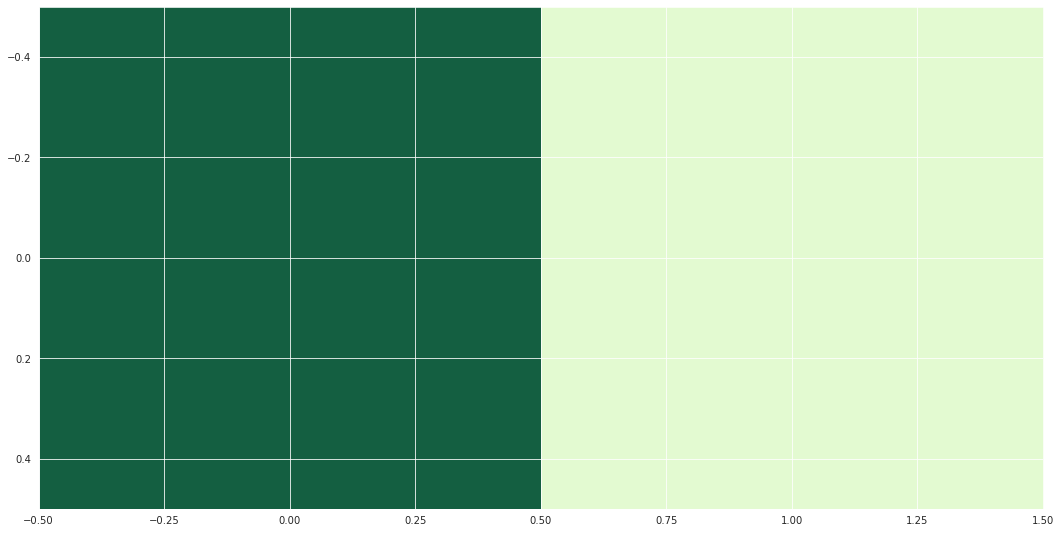

In [19]:
#Dimensions 1 x 2 x 3 (1 x N x 3 matrix)
plt.imshow([colors])
plt.show()

In [25]:
r = []
g = []
b = []

In [26]:
# Import image class of matplotlib
import matplotlib.image as img

# Read batman image and print dimensions
batman_image = img.imread('data/batman.jpg')
print(batman_image.shape)

# Store RGB values of all pixels in lists r, g and b
for pixel in batman_image:
    for temp_r, temp_g, temp_b in pixel:
        r.append(temp_r)
        g.append(temp_g)
        b.append(temp_b)

(169, 269, 3)
